In [21]:
# !pip freeze > /Users/ASUS/Desktop/workplace/kaggle_pj/requestments_torch_cuda.txt

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import zipfile
import warnings
warnings.filterwarnings('ignore')


from torch.utils.data import Dataset, DataLoader
from torchcontrib.optim import SWA

from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2


import joblib
from tqdm.auto import tqdm
print('cuda on : ', torch.cuda.is_available())

cuda on :  True


In [23]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [24]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [25]:
# config

index = 0
HEIGHT = 256
WIDTH = 256

data_dir = "/Users/ASUS/Desktop/test/human-protein-atlas-image-classification/"


In [26]:
df_train = pd.read_csv(f'{data_dir}/train.csv')

In [27]:
%%time
df_train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


# EDA

In [28]:
reverse_train_labels = dict((v,k) for k,v in name_label_dict.items())

In [29]:
reverse_train_labels

{'Nucleoplasm': 0,
 'Nuclear membrane': 1,
 'Nucleoli': 2,
 'Nucleoli fibrillar center': 3,
 'Nuclear speckles': 4,
 'Nuclear bodies': 5,
 'Endoplasmic reticulum': 6,
 'Golgi apparatus': 7,
 'Peroxisomes': 8,
 'Endosomes': 9,
 'Lysosomes': 10,
 'Intermediate filaments': 11,
 'Actin filaments': 12,
 'Focal adhesion sites': 13,
 'Microtubules': 14,
 'Microtubule ends': 15,
 'Cytokinetic bridge': 16,
 'Mitotic spindle': 17,
 'Microtubule organizing center': 18,
 'Centrosome': 19,
 'Lipid droplets': 20,
 'Plasma membrane': 21,
 'Cell junctions': 22,
 'Mitochondria': 23,
 'Aggresome': 24,
 'Cytosol': 25,
 'Cytoplasmic bodies': 26,
 'Rods & rings': 27}

In [30]:
for key in name_label_dict.keys():
    df_train[name_label_dict[key]] = 0

In [31]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)  # label -> list(int)로 변경 index matching
    for num in row.Target:
        name = name_label_dict[int(num)]
        row.loc[name] = 1
    return row

df_train = df_train.apply(fill_targets, axis=1)   #label_dict와 Target match
df_train.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

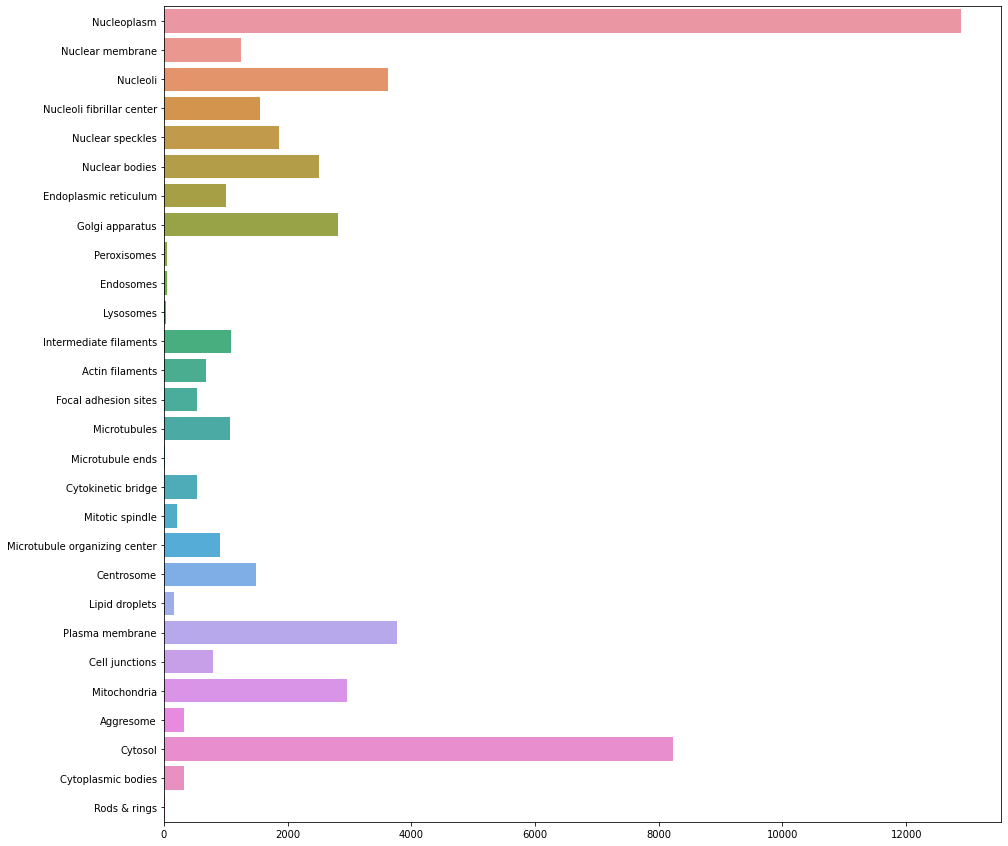

In [32]:
# Data 시각화  -> dataset bias가 높음

target_counts = df_train.drop(["Id", "Target"],axis=1).sum(axis=0)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Text(0, 0.5, '% of train data')

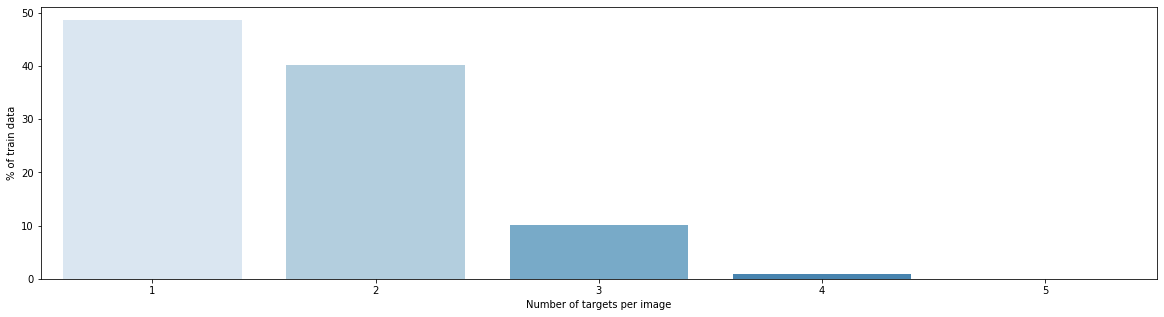

In [33]:
# 멀티 레이블을 가지는 사진의 비율 시각화, 1장의 image가 가지는 최대 레이블은 5개,   1~3개의 label을 가지는 비율이 90%에 가까움

df_train["number_of_targets"] = df_train.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * df_train["number_of_targets"].value_counts() / df_train.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Blues")
plt.xlabel("Number of targets per image")
plt.ylabel("% of train data")

<AxesSubplot:>

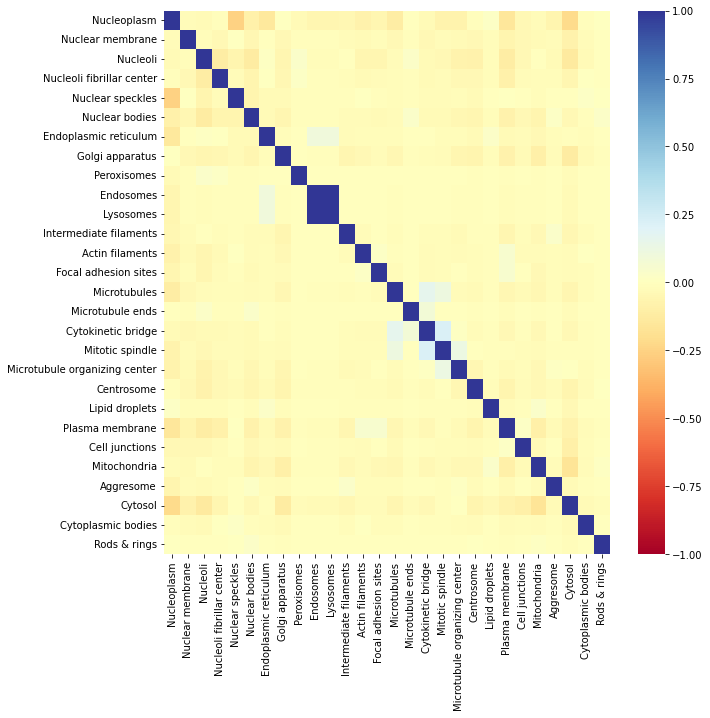

In [34]:
# 레이블 간의 상관관계 분석. 상관성이 있는 label들 확인

plt.figure(figsize=(10,10))
sns.heatmap(df_train[df_train.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

# DataSet Split

In [35]:
train_files = os.listdir(f"{data_dir}/train")
test_files = os.listdir(f"{data_dir}/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print(f"train_data_set 대비 test_data_set이 {percentage} % 비율")

train_data_set 대비 test_data_set이 38.0 % 비율


In [36]:
# train  test 비율이 38%지만 학습효율을 위해 3:1로 split
splitter = RepeatedKFold(n_splits=4, n_repeats=1, random_state=950221)

In [37]:
partitions = []

for train_idx, test_idx in splitter.split(df_train.index.values):
    partition = {}
    partition["train"] = df_train.Id.values[train_idx]
    partition["validation"] = df_train.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx,"" "validation:", test_idx)
    print("TRAIN:", len(train_idx), "validation:", len(test_idx))
    print('')

TRAIN: [    0     1     2 ... 31069 31070 31071] validation: [    6    12    18 ... 31064 31066 31068]
TRAIN: 23304 validation: 7768

TRAIN: [    0     1     2 ... 31068 31069 31071] validation: [    3    11    21 ... 31060 31065 31070]
TRAIN: 23304 validation: 7768

TRAIN: [    0     1     3 ... 31069 31070 31071] validation: [    2     8     9 ... 31056 31063 31067]
TRAIN: 23304 validation: 7768

TRAIN: [    2     3     6 ... 31067 31068 31070] validation: [    0     1     4 ... 31062 31069 31071]
TRAIN: 23304 validation: 7768



In [38]:
for idx, part in enumerate(partitions):
    globals()[f'df_train_f{idx}'] = df_train[df_train.Id.isin(part['train'], )]
    globals()[f'df_valid_f{idx}'] = df_train[df_train.Id.isin(part['validation'], )]

In [39]:
df_valid_f1

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings,number_of_targets
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,00301238-bbb2-11e8-b2ba-ac1f6b6435d0,[21],0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
21,0047c984-bba6-11e8-b2ba-ac1f6b6435d0,[11],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22,00481c70-bba3-11e8-b2b9-ac1f6b6435d0,"[25, 2]",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
23,004a2b84-bbc4-11e8-b2bc-ac1f6b6435d0,"[25, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31048,ffbebc4e-bb9a-11e8-b2b9-ac1f6b6435d0,[4],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31053,ffcf84d6-bbac-11e8-b2ba-ac1f6b6435d0,[0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31060,ffdbe064-bbbb-11e8-b2ba-ac1f6b6435d0,[23],0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
31065,ffe8cf0c-bba9-11e8-b2ba-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Define dataset

In [ ]:
train_dataset_info = []
for name, labels in zip(df_train['Id'], df_train['Target']):
    train_dataset_info.append({
        'path':os.path.join(data_dir+ 'train', name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [ ]:
def create_train(dataset_info, batch_size, shape, augument=False):
    while True:
        dataset_info = shuffle(dataset_info)
        for start in range(0, len(dataset_info), batch_size):
            end = min(start + batch_size, len(dataset_info))
            batch_images = []
            X_train_batch = dataset_info[start:end]
            batch_labels = np.zeros((len(X_train_batch), 28))
            for i in range(len(X_train_batch)):
                image = load_image(
                    X_train_batch[i]['path'], shape)   
                if augument:
                    image = A.augment(image)
                batch_images.append(image/255.)
                batch_labels[i][X_train_batch[i]['labels']] = 1
            yield np.array(batch_images, np.float32), batch_labels
            
            
def load_image(path, shape):
    image_red_ch = Image.open(path+'_red.png')
    image_yellow_ch = Image.open(path+'_yellow.png')
    image_green_ch = Image.open(path+'_green.png')
    image_blue_ch = Image.open(path+'_blue.png')
    image = np.stack([
    np.array(image_red_ch), 
    np.array(image_green_ch), 
    np.array(image_blue_ch),
    np.array(image_yellow_ch)][:shape[2]], -1)
    image = cv2.resize(image, (shape[0], shape[1]))
    return image

In [ ]:
train_images = create_train(dataset_info= train_dataset_info, batch_size= 32, shape= (512,512,4), augument= False)

In [177]:
class HPA_Dataset(Dataset):
  def __init__(self, csv, img_height, img_width, transform):
    self.csv = csv.reset_index()
    self.img_ids = csv['Id'].values
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform


  def __len__(self):
    return len(self.csv)


  def __getitem__(self, index):
    img_id = self.img_ids[index]
    img_red_ch = Image.open(f'{data_dir}/train/{img_id}'+'_red.png')
    img_green_ch = Image.open(f'{data_dir}/train/{img_id}'+'_green.png')
    img_blue_ch = Image.open(f'{data_dir}/train/{img_id}'+'_blue.png')
    img_yellow_ch = Image.open(f'{data_dir}/train/{img_id}'+'_yellow.png')
    
    img = np.stack([
    np.array(img_red_ch), 
    np.array(img_green_ch), 
    np.array(img_blue_ch),
    np.array(img_yellow_ch)], -1)
    
    img = cv2.resize(img, (self.img_height,  self.img_width)).astype(np.uint8)/255
#     img = torch.Tensor(img).permute(2,0,1).numpy()
    
    if self.transform is not None:
      img = self.transform(image = img)['image']

    label = self.csv.iloc[:,3:-1].iloc[index]
    
    return img, np.array(label)

# Define augmentations

In [90]:
train_aug = A.Compose([
    A.Rotate(20),
    A.pytorch.transforms.ToTensorV2()
])

vaild_aug = A.Compose([
    A.pytorch.transforms.ToTensorV2()
])

# Make dataloader

In [180]:
trn_dataset = HPA_Dataset(csv = df_train_f0,
                             img_height = HEIGHT,
                             img_width = WIDTH,
                             transform = train_aug,
                          )

vld_dataset = HPA_Dataset(csv = df_valid_f0,
                            img_height = HEIGHT,
                            img_width = WIDTH,
                            transform = vaild_aug)


In [182]:
i[1]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [183]:
trn_loader = DataLoader(trn_dataset,
                       shuffle = False,
#                        num_workers = 2,
                       batch_size = 32,
                       )

vld_loader = DataLoader(vld_dataset,
                       batch_size = 32,
                       )

In [184]:
%%time
for inputs, targets in tqdm(trn_loader):
    break


  0%|          | 0/729 [00:00<?, ?it/s]

CPU times: total: 453 ms
Wall time: 372 ms


In [ ]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,LABELS))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

In [ ]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [ ]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        return open_rgby(self.path,self.fnames[i])
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [ ]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [ ]:
bs = 16
sz = 256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.aug_dl))
x.shape, y.shape

In [ ]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))